In [1]:
import pandas as pd
import numpy as np

from scipy import stats

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\Abhishek\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [35]:
# load train and test files
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [36]:
# size of training and test set
print train.shape
print test.shape

(260753, 299)
(173836, 298)


In [37]:
# transform column names to lowercase
train.columns = train.columns.map(lambda x: x.lower())
test.columns = test.columns.map(lambda x: x.lower())

In [38]:
# label encode categorical features
from sklearn.preprocessing import LabelEncoder

categorical_features_train = train.select_dtypes(include=['object'])
categorical_features_test = train.select_dtypes(include=['object'])

categorical_features = categorical_features_train.columns.drop('original_quote_date')

categorical_features_train = categorical_features_train[categorical_features]
categorical_features_test = categorical_features_test[categorical_features]

for col in categorical_features:
    total_values = pd.concat([categorical_features_train[col], categorical_features_test[col]], axis=0)
    
    lbl = LabelEncoder()
    
    lbl.fit(total_values)
    categorical_features_train[col] = lbl.transform(categorical_features_train[col])
    categorical_features_test[col] = lbl.transform(categorical_features_test[col])

train[categorical_features] = categorical_features_train
test[categorical_features] = categorical_features_test

In [42]:
# drop the original_quote_date feature
train = train.drop('original_quote_date', axis=1)
test = test.drop('original_quote_date', axis=1)

In [44]:
# fill missing value with -999 to indicate that this is a missing value

train = train.fillna(-999)
test = test.fillna(-999)

In [55]:
# take stratified sample from the dataset ( only 20% of the total examples )
from sklearn.cross_validation import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(train.quoteconversion_flag, train_size=0.5)
train_index, test_index = next(iter(sss))

train_sample = train.ix[train_index]

In [56]:
# separate features and target variable
train_features = train_sample[train_sample.columns.drop('quoteconversion_flag')]
target = train_sample.quoteconversion_flag

test_features = test

In [57]:
# size of the samples
train_features.shape

(130376, 297)

In [58]:
# divide into training and test set
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_features, target, test_size=0.3, random_state=0)

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [60]:
# create pipeline containing standard scaler and logistic regression classifier
scaler = StandardScaler()

pca = PCA(n_components=200, whiten=True)

log = LogisticRegression()
rf = RandomForestClassifier(n_estimators=75)
gbc = GradientBoostingClassifier()

clf = Pipeline([('rf', rf)])
clf = clf.set_params(rf__class_weight='auto', rf__n_jobs=-1)

In [61]:
# train on the training set
clf.fit(X_train, y_train)

Pipeline(steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [62]:
# predictions on the test set
y_test_preds = clf.predict_proba(X_test)[:, 1]

In [63]:
# test your AUC score on the test set
from sklearn.metrics import roc_auc_score

print 'AUC score on the test set %f ' %(roc_auc_score(y_test, y_test_preds))

AUC score on the test set 0.952326 


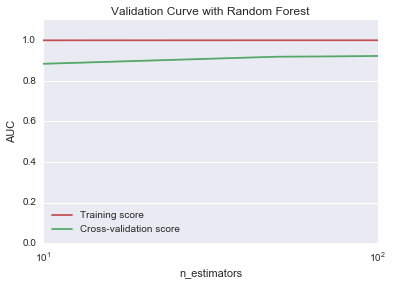

In [13]:
# validation curves
from sklearn.learning_curve import validation_curve

param_range = [10, 50, 75, 100]
train_scores, test_scores = validation_curve(
    RandomForestClassifier(), train_features, target, param_name="n_estimators", param_range=param_range,
    cv=3, scoring="roc_auc", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Random Forest")
plt.xlabel("n_estimators")
plt.ylabel("AUC")
plt.xlim(10, 100)
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

In [64]:
# train on full dataset
clf.fit(train_features, target)

Pipeline(steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [65]:
# predictions
predictions = clf.predict_proba(test_features)[:, 1]

In [66]:
# create submission file
submission = pd.read_csv('./data/sample_submission.csv')
submission['QuoteConversion_Flag'] = predictions
submission.to_csv('./submissions/sixth_submission.csv', index=False)